# DBSLMM

This tool [DBSLMM](https://biostat0903.github.io/DBSLMM/Manual.html) is implemented in R and requires:

1. **Heritability value** - This can be calculated using LDpred-2, which further relies on ldsc to calculate heritability. Other tools can also be used to estimate heritability, and the value can be passed in the DBSLMM command.

2. **Optional reference panel** - It is optional. We used the reference panel from LDAK, which is the same as the one used for PRSice-2.

3. **GWAS format** - The GWAS should be in GEMMA file format. [GEMMA](https://github.com/genetics-statistics/GEMMA).

DBSLMM requires the block information from Berisa and Pickrell (2015). You can download the block information from [here](https://bitbucket.org/nygcresearch/ldetect-data/src/master/).

 
For a specific population, which in our case was EUR, follow these steps:

1. Download the file:  
   [fourier_ls-all.bed](https://bitbucket.org/nygcresearch/ldetect-data/src/master/EUR/fourier_ls-all.bed)

2. Rename the file to `DBSLMM_EUR_FILE.bed` and place it in the working directory.

 
To install and load the `optparse` package in R, use the following commands:

```r
install.packages("optparse")
library(optparse)
```

## Download DBSLMM

Download DBSLMM to the current working directory using the following command:

```bash
git clone https://github.com/biostat0903/DBSLMM
```

Alternatively, visit the [DBSLMM GitHub repository](https://github.com/biostat0903/DBSLMM).
 



## LD Reference Panel
DBSLMM allows the use of the LD reference panel when calculating the Polygenic Risk Score (PRS). We followed the tutorial outlined in [this document](https://dougspeed.com/reference-panel/) with minor modifications to incorporate the LD reference panel into the process.

 

### LD Calculation
Various PRS tools use LD files in different formats. If a tool utilizes an LD reference, the specifics will be explained in the documentation of each tool.

There are two methods to obtain the LD reference:
1. For DBSLMM, we followed the process outlined [here](https://dougspeed.com/reference-panel/) for LD calculation, as the data pertains to the European population.
2. Alternatively, you can download the 1000 Genome project, calculate the LD with specific parameters, and extract SNPs from the LD file.

**Use Linux for LD calculation using this https://dougspeed.com/reference-panel/ tutorial.**

Download [Plink2](https://www.cog-genomics.org/plink/2.0/) as recommended by the author of the above-mentioned tutorial.

**Using an external reference panel for any tool restricts the analysis to the SNPs remaining after clumping and pruning and the ones that exist in the data.**

```bash
wget https://www.dropbox.com/s/y6ytfoybz48dc0u/all_phase3.pgen.zst
wget https://www.dropbox.com/s/odlexvo8fummcvt/all_phase3.pvar.zst
wget https://www.dropbox.com/s/6ppo144ikdzery5/phase3_corrected.psam

./plink2 --zst-decompress all_phase3.pgen.zst > all_phase3_ns.pgen
./plink2 --zst-decompress all_phase3.pvar.zst > all_phase3_ns.pvar

awk < phase3_corrected.psam '($5=="EUR" && $6!="FIN"){print 0, $1}' > eur.keep
echo "." > exclude.snps
./plink2 --make-bed --out raw --pgen all_phase3_ns.pgen --pvar all_phase3_ns.pvar --psam phase3_corrected.psam --maf 0.01 --autosome --snps-only just-acgt --max-alleles 2 --rm-dup exclude-all --exclude exclude.snps --keep eur.keep
awk '(NR==FNR){arr[$1]=$5"_"$6;ars[$1]=$4;next}{$1=$2;$2=arr[$1];$5=ars[$1];print $0}' phase3_corrected.psam raw.fam > clean.fam
cp raw.bim clean.bim
cp raw.bed clean.bed
wget https://www.dropbox.com/s/slchsd0uyd4hii8/genetic_map_b37.zip
unzip genetic_map_b37.zip
./plink --bfile clean --cm-map genetic_map_b37/genetic_map_chr@_combined_b37.txt --make-bed --out ref
```

### LD Parameters

1. We considered the LD reference panel from LDAK, named `ref`.
2. Alternatively, you can pass a genotype binary file as the reference panel.



## Using LDpred-2 to Calculate h2

When calculating correlation for h2 calculation using LDpred-2, the following arguments should be passed, which are the same as the clumping parameters. These arguments should be passed to the R file when calculating h2.

1. `size = clump_kb = [200]`
   For one SNP, window size around this SNP to compute correlations. Default is 500. If not providing infos.pos (NULL, the default), this is a window in the number of SNPs, otherwise, it is a window in kb (genetic distance).

2. `alpha = clump_p1 = [1]`
   Type-I error for testing correlations. Default is 1 (no threshold is applied).

3. `thr_r2 = clump_r2 = [0.1]`
   Threshold to apply on squared correlations. Default is 0.

The above information is taken from:

```R
library(bigsnpr)
options(bigstatsr.check.parallel.blas = FALSE)
options(default.nproc.blas = NULL)
library(data.table)
library(magrittr)
help(snp_cor)
```

The following code shows the process to calcuate the h2 using LDpred-2.

Actual code in `GCTA_R_1.R`

### Arguments
1. Argument one is the directory. Example: `SampleData1`
2. Argument two is the file name. Example: `SampleData1\\Fold_0`
3. Argument three is the output file name. Example: `train_data`
4. Argument four is the specific function to be called. Example: `train_data.QC.clumped.pruned`

5. Argument five is LDpred-2 option. Example: `LDpred-2_full` or `LDpred-2_hapmap`
6. Argument six is the size parameter. Example: `200`
7. Argument seven is the alpha parameter. Example: `1`
8. Argument eight is the thr_r2 parameter. Example: `0.1`
9. Argument nine is the number of PCA. Example: `6`

#### Sample values
1. "SampleData1"
2. "SampleData1\\Fold_0"
3. "train_data"
4. "train_data.QC.clumped.pruned"
5. "2"
6. "200"
7. "1"
8. "0.1"
9. "6"




#### `LDpred-2_hapmap`

```R
  # Load libraries.
  library(bigsnpr)
  options(bigstatsr.check.parallel.blas = FALSE)
  options(default.nproc.blas = NULL)
  library(data.table)
  library(magrittr)
  # Load phenotype file.
  result <-paste(".",args[2],paste(args[3],toString(".PHENO"), sep = ""),sep="//")
  phenotype <- fread(result)
  # Load covariate file.
  result <-paste(".",args[2],paste(args[3],toString(".cov"), sep = ""),sep="//")
  covariate <- fread(result)
  # Load PCA.
  result <-paste(".",args[2],paste(args[3],toString(".eigenvec"), sep = ""),sep="//")
  pcs <- fread(result)
  # Rename columns
  colnames(pcs) <- c("FID","IID", paste0("PC",1:as.numeric(args[9])))
  # Merge phenotype, covariate and PCA.
  pheno <- merge(phenotype, covariate) %>%
    merge(., pcs)
  # Download hapmap information from LDpred-2
  info <- readRDS(runonce::download_file(
    "https://ndownloader.figshare.com/files/25503788",
    fname = "map_hm3_ldpred2.rds"))
  # Read in the summary statistic file
  result <-paste(".",args[1],paste(args[1],toString(".txt"), sep = ""),sep="//")
  
  sumstats <- bigreadr::fread2(result) 
  # LDpred 2 require the header to follow the exact naming
  names(sumstats) <-
    c("chr",
      "pos",
      "rsid",
      "a1",
      "a0",
      "n_eff",
      "beta_se",
      "p",
      "OR",
      "INFO",
      "MAF")
  # Transform the OR into log(OR)
  sumstats$beta <- log(sumstats$OR)
  # Filter out hapmap SNPs
  # Restrict analysis to SNPs common in Hapmap SNPs and summmary file SNPs.
  sumstats <- sumstats[sumstats$rsid%in% info$rsid,]
  
  # Get maximum amount of cores
  NCORES <- nb_cores()
  # Open a temporary file
  
  if (dir.exists("tmp-data")) {
    # Delete the directory and its contents
    system(paste("rm -r", shQuote("tmp-data")))
    print(paste("Directory", "tmp-data", "deleted."))
  }
  tmp <- tempfile(tmpdir = "tmp-data")
  on.exit(file.remove(paste0(tmp, ".sbk")), add = TRUE)
  # Initialize variables for storing the LD score and LD matrix
  corr <- NULL
  ld <- NULL
  # We want to know the ordering of samples in the bed file 
  fam.order <- NULL
  # Preprocess the bed file (only need to do once for each data set)
  result <-paste(".",args[2],paste(args[4],toString(".rds"), sep = ""),sep="//")
  if (file.exists(result)) {
    file.remove(result)
    print(paste("File", result, "deleted."))
  }
  result <-paste(".",args[2],paste(args[4],toString(".bk"), sep = ""),sep="//")
  if (file.exists(result)) {
    file.remove(result)
    print(paste("File", result, "deleted."))
  }
  
  
  result <-paste(".",args[2],paste(args[4],toString(".bed"), sep = ""),sep="//")
  
  snp_readBed(result)
  # Now attach the genotype object
  result <-paste(".",args[2],paste(args[4],toString(".rds"), sep = ""),sep="//")
  
  obj.bigSNP <- snp_attach(result)
  
  # Extract the SNP information from the genotype
  map <- obj.bigSNP$map[-3]
 
  names(map) <- c("chr", "rsid", "pos", "a1", "a0")
 
  # perform SNP matching
  info_snp <- snp_match(sumstats, map)
  help(snp_match)
  info_snp
  # Assign the genotype to a variable for easier downstream analysis
  genotype <- obj.bigSNP$genotypes
  # Rename the data structures
  CHR <- map$chr
  POS <- map$pos
  # get the CM information from 1000 Genome
  # will download the 1000G file to the current directory (".")
  #help(snp_asGeneticPos)
  POS2 <- snp_asGeneticPos(CHR, POS, dir = ".")
 
  
  for (chr in 1:22) {
    # Extract SNPs that are included in the chromosome
    
    ind.chr <- which(info_snp$chr == chr)
    print(length(ind.chr))
    ind.chr2 <- info_snp$`_NUM_ID_`[ind.chr]
    ind.chr2
    print(length(ind.chr2))
    
    # Calculate the LD
    help(snp_cor)
    corr0 <- snp_cor(
      genotype,
      ind.col = ind.chr2,
      ncores = NCORES,
      infos.pos = POS2[ind.chr2],
      #size = 200,
      #thr_r2=0.1,
      #alpha = 1
      
      size = as.numeric(args[6]),
      alpha = as.numeric(args[7]),
      
      thr_r2=as.numeric(args[8]),
        )
    if (chr == 1) {
      ld <- Matrix::colSums(corr0^2)
      help(as_SFBM)
      corr <- as_SFBM(corr0, tmp)
    } else {
      ld <- c(ld, Matrix::colSums(corr0^2))
      corr$add_columns(corr0, nrow(corr))
    }
  }
  
  
  # We assume the fam order is the same across different chromosomes
  fam.order <- as.data.table(obj.bigSNP$fam)
  # Rename fam order
  setnames(fam.order,
           c("family.ID", "sample.ID"),
           c("FID", "IID"))
  
  df_beta <- info_snp[,c("beta", "beta_se", "n_eff", "_NUM_ID_")]
  
  length(df_beta$beta) 
  length(ld)
  help(snp_ldsc)
  ldsc <- snp_ldsc(ld, 
                   length(ld), 
                   chi2 = (df_beta$beta / df_beta$beta_se)^2,
                   sample_size = df_beta$n_eff, 
                   blocks = NULL)
  h2_est <- ldsc[["h2"]]
  h2_est
  
  if (file.exists("ldpred_h2_hapmap.txt")) {
    file.remove("ldpred_h2_hapmap.txt")
    print(paste("File", result, "deleted."))
  }
  write.table(h2_est, file = "ldpred_h2_hapmap.txt", col.names = FALSE)
  
  if (file.exists("ldpred_h2_variants.txt")) {
    file.remove("ldpred_h2_variants.txt")
    print(paste("File", result, "deleted."))
  }
  write.table(length(ld), file = "ldpred_h2_variants.txt", col.names = FALSE)
```




#### `LDpred-2_full`


```R
  library(bigsnpr)
  options(bigstatsr.check.parallel.blas = FALSE)
  options(default.nproc.blas = NULL)
  library(data.table)
  library(magrittr)
  result <-paste(".",args[2],paste(args[3],toString(".PHENO"), sep = ""),sep="//")
  phenotype <- fread(result)
  result <-paste(".",args[2],paste(args[3],toString(".cov"), sep = ""),sep="//")
  covariate <- fread(result)
  result <-paste(".",args[2],paste(args[3],toString(".eigenvec"), sep = ""),sep="//")
  pcs <- fread(result)
  # rename columns
  colnames(pcs) <- c("FID","IID", paste0("PC",1:as.numeric(args[9])))
  # generate required table
  pheno <- merge(phenotype, covariate) %>%
    merge(., pcs)
  info <- readRDS(runonce::download_file(
    "https://ndownloader.figshare.com/files/25503788",
    fname = "map_hm3_ldpred2.rds"))
  # Read in the summary statistic file
  result <-paste(".",args[1],paste(args[1],toString(".txt"), sep = ""),sep="//")
  
  sumstats <- bigreadr::fread2(result) 
  # LDpred 2 require the header to follow the exact naming
  names(sumstats) <-
    c("chr",
      "pos",
      "rsid",
      "a1",
      "a0",
      "n_eff",
      "beta_se",
      "p",
      "OR",
      "INFO",
      "MAF")
  # Transform the OR into log(OR)
  sumstats$beta <- log(sumstats$OR)
  # Filter out hapmap SNPs
  # Turn off this line to ensure that all the SNPs from the sumstats are included.
  # Restrict analysis to SNPs common in Hapmap SNPs and summmary file SNPs
  #sumstats <- sumstats[sumstats$rsid%in% info$rsid,]
  
  # Get maximum amount of cores
  NCORES <- nb_cores()
  # Open a temporary file
  
  if (dir.exists("tmp-data")) {
    # Delete the directory and its contents
    
    system(paste("rm -r", shQuote("tmp-data")))
    print(paste("Directory", "tmp-data", "deleted."))
  }
  tmp <- tempfile(tmpdir = "tmp-data")
  on.exit(file.remove(paste0(tmp, ".sbk")), add = TRUE)
  # Initialize variables for storing the LD score and LD matrix
  corr <- NULL
  ld <- NULL
  # We want to know the ordering of samples in the bed file 
  fam.order <- NULL
  # preprocess the bed file (only need to do once for each data set)
  result <-paste(".",args[2],paste(args[4],toString(".rds"), sep = ""),sep="//")
  if (file.exists(result)) {
    file.remove(result)
    print(paste("File", result, "deleted."))
  }
  result <-paste(".",args[2],paste(args[4],toString(".bk"), sep = ""),sep="//")
  if (file.exists(result)) {
    file.remove(result)
    print(paste("File", result, "deleted."))
  }
  
  
  result <-paste(".",args[2],paste(args[4],toString(".bed"), sep = ""),sep="//")
  
  snp_readBed(result)
  # now attach the genotype object
  result <-paste(".",args[2],paste(args[4],toString(".rds"), sep = ""),sep="//")
  
  obj.bigSNP <- snp_attach(result)
  
  # extract the SNP information from the genotype
  map <- obj.bigSNP$map[-3]
  
  names(map) <- c("chr", "rsid", "pos", "a1", "a0")
  
  # perform SNP matching
  info_snp <- snp_match(sumstats, map)
  help(snp_match)
  info_snp
  # Assign the genotype to a variable for easier downstream analysis
  genotype <- obj.bigSNP$genotypes
  # Rename the data structures
  CHR <- map$chr
  POS <- map$pos
  # get the CM information from 1000 Genome
  # will download the 1000G file to the current directory (".")
  #help(snp_asGeneticPos)
  POS2 <- snp_asGeneticPos(CHR, POS, dir = ".")
  
  
  for (chr in 1:22) {
    # Extract SNPs that are included in the chromosome
    
    ind.chr <- which(info_snp$chr == chr)
    print(length(ind.chr))
    ind.chr2 <- info_snp$`_NUM_ID_`[ind.chr]
 
    print(length(ind.chr2))
    
    # Calculate the LD
    help(snp_cor)
    corr0 <- snp_cor(
      genotype,
      ind.col = ind.chr,
      ncores = NCORES,
      infos.pos = POS2[ind.chr2],
      #size = 200,
      #thr_r2=0.1,
      #alpha = 1
      
      size = as.numeric(args[6]),
      alpha = as.numeric(args[7]),
      thr_r2=as.numeric(args[8]),
    )
    if (chr == 1) {
      ld <- Matrix::colSums(corr0^2)
      help(as_SFBM)
      corr <- as_SFBM(corr0, tmp)
    } else {
      ld <- c(ld, Matrix::colSums(corr0^2))
      corr$add_columns(corr0, nrow(corr))
    }
  }
  
  
  # We assume the fam order is the same across different chromosomes
  fam.order <- as.data.table(obj.bigSNP$fam)
  # Rename fam order
  setnames(fam.order,
           c("family.ID", "sample.ID"),
           c("FID", "IID"))
  
  df_beta <- info_snp[,c("beta", "beta_se", "n_eff", "_NUM_ID_")]
  
  length(df_beta$beta) 
  length(ld)
  help(snp_ldsc)
  ldsc <- snp_ldsc(ld, 
                   length(ld), 
                   chi2 = (df_beta$beta / df_beta$beta_se)^2,
                   sample_size = df_beta$n_eff, 
                   blocks = NULL)
  h2_est <- ldsc[["h2"]]
 
  
  if (file.exists("ldpred_h2_full.txt")) {
    file.remove("ldpred_h2_full.txt")
    print(paste("File", result, "deleted."))
  }
  
  write.table(h2_est, file = "ldpred_h2_full.txt", col.names = FALSE)
``` 
 




## GWAS file processing for DBSLMM.
 **GWAS format** - The GWAS should be in GEMMA file format. [GEMMA](https://github.com/genetics-statistics/GEMMA).




In [1]:

import os
import pandas as pd
import numpy as np
import sys
import os
import pandas as pd
import numpy as np

def check_phenotype_is_binary_or_continous(filedirec):
    # Read the processed quality controlled file for a phenotype
    df = pd.read_csv(filedirec+os.sep+filedirec+'_QC.fam',sep="\s+",header=None)
    column_values = df[5].unique()
 
    if len(set(column_values)) == 2:
        return "Binary"
    else:
        return "Continous"
    

#iledirec = sys.argv[1]

filedirec = "SampleData1"
#filedirec = "asthma_19"


# Read the GWAS file.
GWAS = filedirec + os.sep + filedirec+".gz"
df = pd.read_csv(GWAS,compression= "gzip",sep="\s+")

if "BETA" in df.columns.to_list():
    # For Continous Phenotype.
    df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

else:
    df["BETA"] = np.log(df["OR"])
    df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

# Convert 'P' column to float
df['P'] = df['P'].astype(float)

# Print initial length of DataFrame
print("Initial length:", len(df))



 
print("Final length:", len(df))


# Save this file as it will be used to caulcate hertiability using LDpred-2.
df.to_csv(filedirec + os.sep +filedirec+".txt",sep="\t",index=False)



if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
    if "BETA" in df.columns.to_list():
        # For Binary Phenotypes.
        df["OR"] = np.exp(df["BETA"])
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'OR', 'INFO', 'MAF']]
    else:
        # For Binary Phenotype.
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'OR', 'INFO', 'MAF']]
     
    df_transformed = pd.DataFrame({
    'chr': df['CHR'],
    'rs': df['SNP'],
    'ps': df['BP'],
    'n_mis': 0,  
    'n_obs': df['N'],
    'allele1': df['A1'],
    'allele0': df['A2'],
    'af': df['MAF'],
    'or': df['OR'],
    'se': df['SE'],
    'p_wald': df['P']
    })
    
elif check_phenotype_is_binary_or_continous(filedirec)=="Continous":
    if "BETA" in df.columns.to_list():
        # For Continous Phenotype.
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]

    else:
        df["BETA"] = np.log(df["OR"])
        df = df[['CHR', 'BP', 'SNP', 'A1', 'A2', 'N', 'SE', 'P', 'BETA', 'INFO', 'MAF']]
    
    
  

    df_transformed = pd.DataFrame({
    'chr': df['CHR'],
    'rs': df['SNP'],
    'ps': df['BP'],
    'n_mis': 0,  
    'n_obs': df['N'],
    'allele1': df['A1'],
    'allele0': df['A2'],
    'af': df['MAF'],
    'beta': df['BETA'],
    'se': df['SE'],
    'p_wald': df['P']
    })

# Note: When i executed DBSLMM for multiple datasets, the code was breaking, may be because of a lot of variants.
# Once can reduce the number of SNPs to be considered for the analsysis using df['P'] < 0.001. Lower the value
# the SNPs with high assoction will  be considered.
# If the betas are NAN, try reducing the number of SNPs by reducing P-value threshold df['P'] < 0.001
"""Rscript DBSLMM/software/DBSLMM.R --summary high_cholesterol/high_cholesterol_DBSLMM.txt --outPath high_cholesterol/Fold_1/DBSLMM --plink ./plink --dbslmm DBSLMM/software/dbslmm --ref high_cholesterol/Fold_1/train_data.QC --model DBSLMM --mafMax 0.9 --n 464736.0 --nsnp 619652 --block DBSLMM_EUR_FILE.bed --h2 0.1
Error: p-value > 1 on line 9 of high_cholesterol/Fold_1/DBSLMMplink_.txt.
Using 1e-6, no significant SNPs.
Clumping time:  18.213 s.
Reading PLINK FAM file from [high_cholesterol/Fold_1/train_data.QC.fam]
586 individuals to be included from reference FAM file.
Reading PLINK BIM file from [high_cholesterol/Fold_1/train_data.QC.bim]
Calculating MAF of reference panel ...
562199 SNPs to be included from reference BIM file.
Reading summary data of small effect SNPs from [high_cholesterol/high_cholesterol_DBSLMM.txt]
Warning message:
In min(p_val[-which(p_val == 0)]) :
  no non-missing arguments to min; returning Inf
####
"""

print(len(df_transformed))
df_transformed = df_transformed[(df_transformed['p_wald'] < 0.001) & (df_transformed['p_wald'] > 0)]
print(len(df_transformed))

# Save the transformed dataframe to a new pandas file
output_file = filedirec+os.sep+filedirec+"_DBSLMM.txt"
# DBSLMM GWAS input file does not have header. based on the provided sample data.
df_transformed.to_csv(output_file,sep="\t",index=False,header=None)
print(df_transformed.head())


Initial length: 499617
Final length: 43760
43760
43760
     chr          rs       ps  n_mis   n_obs allele1 allele0        af  \
17     1   rs1110052   873558      0  388028       G       T  0.368089   
80     1  rs72894004  1109782      0  388028       A       G  0.386828   
93     1  rs12060422  1129920      0  388028       A       G  0.477565   
100    1     rs11721  1152631      0  388028       A       C  0.367743   
103    1  rs77472198  1159024      0  388028       T       C  0.488815   

         beta        se        p_wald  
17  -0.008184  0.002256  2.856740e-04  
80   0.009137  0.002630  5.134560e-04  
93   0.011865  0.003431  5.445770e-04  
100  0.017804  0.003554  5.460540e-07  
103  0.016634  0.003447  1.396920e-06  


### Define Hyperparameters

Define hyperparameters to be optimized and set initial values.

### Extract Valid SNPs from Clumped File

For Windows, download `gwak`, and for Linux, the `awk` command is sufficient. For Windows, `GWAK` is required. You can download it from [here](https://sourceforge.net/projects/gnuwin32/). Get it and place it in the same directory.


### Execution Path

At this stage, we have the genotype training data `newtrainfilename = "train_data.QC"` and genotype test data `newtestfilename = "test_data.QC"`.

We modified the following variables:

1. `filedirec = "SampleData1"` or `filedirec = sys.argv[1]`
2. `foldnumber = "0"` or `foldnumber = sys.argv[2]` for HPC.

Only these two variables can be modified to execute the code for specific data and specific folds. Though the code can be executed separately for each fold on HPC and separately for each dataset, it is recommended to execute it for multiple diseases and one fold at a time.
Here’s the corrected text in Markdown format:

 
### P-values

PRS calculation relies on P-values. SNPs with low P-values, indicating a high degree of association with a specific trait, are considered for calculation.

You can modify the code below to consider a specific set of P-values and save the file in the same format.

We considered the following parameters:

- **Minimum P-value**: `1e-10`
- **Maximum P-value**: `1.0`
- **Minimum exponent**: `10`  (Minimum P-value in exponent)
- **Number of intervals**: `100`  (Number of intervals to be considered)

The code generates an array of logarithmically spaced P-values:

```python
import numpy as np
import os

minimumpvalue = 10  # Minimum exponent for P-values
numberofintervals = 100  # Number of intervals to be considered

allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced P-values

print("Minimum P-value:", allpvalues[0])
print("Maximum P-value:", allpvalues[-1])

count = 1
with open(os.path.join(folddirec, 'range_list'), 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count += 1

pvaluefile = os.path.join(folddirec, 'range_list')
```

In this code:
- `minimumpvalue` defines the minimum exponent for P-values.
- `numberofintervals` specifies how many intervals to consider.
- `allpvalues` generates an array of P-values spaced logarithmically.
- The script writes these P-values to a file named `range_list` in the specified directory.
 

In [7]:

from operator import index
import pandas as pd
import numpy as np
import os
import subprocess
import sys
import pandas as pd
#import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
#from statsmodels.stats.contingency_tables import mcnemar

def create_directory(directory):
    """Function to create a directory if it doesn't exist."""
    if not os.path.exists(directory):  # Checking if the directory doesn't exist
        os.makedirs(directory)  # Creating the directory if it doesn't exist
    return directory  # Returning the created or existing directory


#foldnumber = sys.argv[1]
foldnumber = "0"  # Setting 'foldnumber' to "0"

folddirec = filedirec + os.sep + "Fold_" + foldnumber  # Creating a directory path for the specific fold
trainfilename = "train_data"  # Setting the name of the training data file
newtrainfilename = "train_data.QC"  # Setting the name of the new training data file

testfilename = "test_data"  # Setting the name of the test data file
newtestfilename = "test_data.QC"  # Setting the name of the new test data file

# Number of PCA to be included as a covariate.
numberofpca = ["6"]  # Setting the number of PCA components to be included

# Clumping parameters.
clump_p1 = [1]  # List containing clump parameter 'p1'
clump_r2 = [0.1]  # List containing clump parameter 'r2'
clump_kb = [200]  # List containing clump parameter 'kb'

# Pruning parameters.
p_window_size = [200]  # List containing pruning parameter 'window_size'
p_slide_size = [50]  # List containing pruning parameter 'slide_size'
p_LD_threshold = [0.25]  # List containing pruning parameter 'LD_threshold'

# Kindly note that the number of p-values to be considered varies, and the actual p-value depends on the dataset as well.
# We will specify the range list here.
minimumpvalue = 10  # Minimum p-value in exponent
numberofintervals = 20  # Number of intervals to be considered
allpvalues = np.logspace(-minimumpvalue, 0, numberofintervals, endpoint=True)  # Generating an array of logarithmically spaced p-values
count = 1
#folddirec = "/path/to/your/folder"  # Replace with your actual folder path

count = 1
with open(folddirec + os.sep + 'range_list', 'w') as file:
    for value in allpvalues:
        file.write(f'pv_{value} 0 {value}\n')  # Writing range information to the 'range_list' file
        count = count + 1
        
pvaluefile = folddirec + os.sep + 'range_list'

# Initializing an empty DataFrame with specified column names
#prs_result = pd.DataFrame(columns=["clump_p1", "clump_r2", "clump_kb", "p_window_size", "p_slide_size", "p_LD_threshold",
#                                   "pvalue", "numberofpca","Train_pure_prs", "Train_null_model", "Train_best_model",
#                                   "Test_pure_prs", "Test_null_model", "Test_best_model"])
#

### Define Helper Functions

1. **Perform Clumping and Pruning**
2. **Calculate PCA Using Plink**
3. **Fit Binary Phenotype and Save Results**
4. **Fit Continuous Phenotype and Save Results**


In [8]:

import os
import subprocess
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import explained_variance_score

# Define a global variable to store results
prs_result = pd.DataFrame()
def perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,numberofpca, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    
    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)
    # First perform pruning and then clumping and the pruning.

    command = [
    "./plink",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--clump-p1", c1_val,
    "--extract", traindirec+os.sep+trainfilename+".prune.in",
    "--clump-r2", c2_val,
    "--clump-kb", c3_val,
    "--clump", filedirec+os.sep+filedirec+".txt",
    "--clump-snp-field", "SNP",
    "--clump-field", "P",
    "--out", traindirec+os.sep+trainfilename
    ]    
    subprocess.run(command)

    # Extract the valid SNPs from th clumped file.
    # For windows download gwak for linux awk commmand is sufficient.
    ### For windows require GWAK.
    ### https://sourceforge.net/projects/gnuwin32/
    ##3 Get it and place it in the same direc.
    #os.system("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")
    #print("gawk "+"\""+"NR!=1{print $3}"+"\"  "+ traindirec+os.sep+trainfilename+".clumped >  "+traindirec+os.sep+trainfilename+".valid.snp")

    #Linux:
    command = f"awk 'NR!=1{{print $3}}' {traindirec}{os.sep}{trainfilename}.clumped > {traindirec}{os.sep}{trainfilename}.valid.snp"
    os.system(command)
    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+newtrainfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+newtrainfilename+".clumped.pruned"
    ]
    subprocess.run(command)
    
    command = [
    "./plink",
    "--make-bed",
    "--bfile", traindirec+os.sep+testfilename,
    "--indep-pairwise", p1_val, p2_val, p3_val,
    "--extract", traindirec+os.sep+trainfilename+".valid.snp",
    "--out", traindirec+os.sep+testfilename+".clumped.pruned"
    ]
    subprocess.run(command)    
    
    
 
def calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p):
    
    # Calculate the PRS for the test data using the same set of SNPs and also calculate the PCA.


    # Also extract the PCA at this point.
    # PCA are calculated afer clumping and pruining.
    command = [
        "./plink",
        "--bfile", folddirec+os.sep+testfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", folddirec+os.sep+testfilename
    ]
    subprocess.run(command)


    command = [
    "./plink",
        "--bfile", traindirec+os.sep+newtrainfilename+".clumped.pruned",
        # Select the final variants after clumping and pruning.        
        "--extract", traindirec+os.sep+trainfilename+".valid.snp",
        "--pca", p,
        "--out", traindirec+os.sep+trainfilename
    ]
    subprocess.run(command)

# This function fit the binary model on the PRS.
def fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,p, h2model, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile,effectsize,ref,heritability):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
      
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                #null_model =  sm.Logit(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue

            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
           
            
            global prs_result 
            for i in threshold_values:
                try:
                    prs_train = pd.read_table(traindirec+os.sep+Name+os.sep+"train_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue

                prs_train['FID'] = prs_train['FID'].astype(str)
                prs_train['IID'] = prs_train['IID'].astype(str)
                try:
                    prs_test = pd.read_table(traindirec+os.sep+Name+os.sep+"test_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue
                prs_test['FID'] = prs_test['FID'].astype(str)
                prs_test['IID'] = prs_test['IID'].astype(str)
                pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
                pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
        
                try:
                    model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                    #model = sm.Logit(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
                
                except:
                    continue


                
                train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
 

                test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 
 
        
                from sklearn.metrics import roc_auc_score, confusion_matrix

                prs_result = prs_result._append({
                    "clump_p1": c1_val,
                    "clump_r2": c2_val,
                    "clump_kb": c3_val,
                    "p_window_size": p1_val,
                    "p_slide_size": p2_val,
                    "p_LD_threshold": p3_val,
                    "pvalue": i,
                    "numberofpca":p, 

                    "tempalpha":str(tempalpha),
                    "l1weight":str(l1weight),
                    "numberofvariants": len(pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned.bim")),
                    "referencepanel": ref,
                    "heritability": heritability,
                    "effectsizes": effectsize,
                    "h2model":h2model, 

                    "Train_pure_prs":roc_auc_score(phenotype_train["Phenotype"].values,prs_train['SCORE'].values),
                    "Train_null_model":roc_auc_score(phenotype_train["Phenotype"].values,train_null_predicted.values),
                    "Train_best_model":roc_auc_score(phenotype_train["Phenotype"].values,train_best_predicted.values),
                    
                    "Test_pure_prs":roc_auc_score(phenotype_test["Phenotype"].values,prs_test['SCORE'].values),
                    "Test_null_model":roc_auc_score(phenotype_test["Phenotype"].values,test_null_predicted.values),
                    "Test_best_model":roc_auc_score(phenotype_test["Phenotype"].values,test_best_predicted.values),
                    
                }, ignore_index=True)

          
                prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return

# This function fit the binary model on the PRS.
def fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,p,h2model, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile,effectsize,ref,heritability):
    threshold_values = allpvalues

    # Merge the covariates, pca and phenotypes.
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_train = pd.DataFrame()
    phenotype_train["Phenotype"] = tempphenotype_train[5].values
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.fillna(0, inplace=True)


    ## Scale the covariates!
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import explained_variance_score
    scaler = MinMaxScaler()
    normalized_values_train = scaler.fit_transform(covandpcs_train.iloc[:, 2:])
    #covandpcs_train.iloc[:, 2:] = normalized_values_test 
    
    tempphenotype_test = pd.read_table(traindirec+os.sep+testfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype_test= pd.DataFrame()
    phenotype_test["Phenotype"] = tempphenotype_test[5].values
    pcs_test = pd.read_table(traindirec+os.sep+testfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_test = pd.read_table(traindirec+os.sep+testfilename+".cov",sep="\s+")
    covariate_test.fillna(0, inplace=True)
    covariate_test = covariate_test[covariate_test["FID"].isin(pcs_test["FID"].values) & covariate_test["IID"].isin(pcs_test["IID"].values)]
    covariate_test['FID'] = covariate_test['FID'].astype(str)
    pcs_test['FID'] = pcs_test['FID'].astype(str)
    covariate_test['IID'] = covariate_test['IID'].astype(str)
    pcs_test['IID'] = pcs_test['IID'].astype(str)
    covandpcs_test = pd.merge(covariate_test, pcs_test, on=["FID","IID"])
    covandpcs_test.fillna(0, inplace=True)
    normalized_values_test  = scaler.transform(covandpcs_test.iloc[:, 2:])
    #covandpcs_test.iloc[:, 2:] = normalized_values_test     
    
    
    
    
    tempalphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    l1weights = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    tempalphas = [0.1]
    l1weights = [0.1]

    #phenotype_train["Phenotype"] = phenotype_train["Phenotype"].replace({1: 0, 2: 1}) 
    #phenotype_test["Phenotype"] = phenotype_test["Phenotype"].replace({1: 0, 2: 1})
      
    for tempalpha in tempalphas:
        for l1weight in l1weights:

            
            try:
                #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
                #null_model =  sm.OLS(phenotype_train["Phenotype"], sm.add_constant(covandpcs_train.iloc[:, 2:])).fit()
            except:
                print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
                continue

            train_null_predicted = null_model.predict(sm.add_constant(covandpcs_train.iloc[:, 2:]))
            
            from sklearn.metrics import roc_auc_score, confusion_matrix
            from sklearn.metrics import r2_score
            
            test_null_predicted = null_model.predict(sm.add_constant(covandpcs_test.iloc[:, 2:]))
            
            
            
            global prs_result 
            for i in threshold_values:
                try:
                    prs_train = pd.read_table(traindirec+os.sep+Name+os.sep+"train_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue

                prs_train['FID'] = prs_train['FID'].astype(str)
                prs_train['IID'] = prs_train['IID'].astype(str)
                try:
                    prs_test = pd.read_table(traindirec+os.sep+Name+os.sep+"test_data.pv_"+f"{i}.profile", sep="\s+", usecols=["FID", "IID", "SCORE"])
                except:
                    continue
                prs_test['FID'] = prs_test['FID'].astype(str)
                prs_test['IID'] = prs_test['IID'].astype(str)
                pheno_prs_train = pd.merge(covandpcs_train, prs_train, on=["FID", "IID"])
                pheno_prs_test = pd.merge(covandpcs_test, prs_test, on=["FID", "IID"])
        
                try:
                    #model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit_regularized(alpha=tempalpha, L1_wt=l1weight)
                    model = sm.OLS(phenotype_train["Phenotype"], sm.add_constant(pheno_prs_train.iloc[:, 2:])).fit()
                
                except:
                    continue


                
                train_best_predicted = model.predict(sm.add_constant(pheno_prs_train.iloc[:, 2:]))    
                test_best_predicted = model.predict(sm.add_constant(pheno_prs_test.iloc[:, 2:])) 
 
        
                from sklearn.metrics import roc_auc_score, confusion_matrix

                prs_result = prs_result._append({
                    "clump_p1": c1_val,
                    "clump_r2": c2_val,
                    "clump_kb": c3_val,
                    "p_window_size": p1_val,
                    "p_slide_size": p2_val,
                    "p_LD_threshold": p3_val,
                    "pvalue": i,
                    "numberofpca":p, 

                    "tempalpha":str(tempalpha),
                    "l1weight":str(l1weight),
                    "numberofvariants": len(pd.read_csv(traindirec+os.sep+newtrainfilename+".clumped.pruned.bim")),
                    "referencepanel": ref,
                    "heritability": heritability,
                    "effectsizes": effectsize,
                    "h2model":h2model,
                    
                    "Train_pure_prs":explained_variance_score(phenotype_train["Phenotype"],prs_train['SCORE'].values),
                    "Train_null_model":explained_variance_score(phenotype_train["Phenotype"],train_null_predicted),
                    "Train_best_model":explained_variance_score(phenotype_train["Phenotype"],train_best_predicted),
                    
                    "Test_pure_prs":explained_variance_score(phenotype_test["Phenotype"],prs_test['SCORE'].values),
                    "Test_null_model":explained_variance_score(phenotype_test["Phenotype"],test_null_predicted),
                    "Test_best_model":explained_variance_score(phenotype_test["Phenotype"],test_best_predicted),
                    
                }, ignore_index=True)

          
                prs_result.to_csv(traindirec+os.sep+Name+os.sep+"Results.csv",index=False)
     
    return



## Execute DBSLMM

In [4]:

def transform_dbslmm_data(traindirec, newtrainfilename,p, h2model,ref,p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile):
    ### First perform clumping on the file and save the clumpled file.
    #perform_clumping_and_pruning_on_individual_data(traindirec, newtrainfilename,p, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile)
     
    #calculate_pca_for_traindata_testdata_for_clumped_pruned_snps(traindirec, newtrainfilename,p)
    
    # At this stage, we will merge the PCA and COV file. 
    import os

    # Define the paths to the files
    files_to_remove = [
        traindirec + os.sep + "DBSLMM.dbslmm.txt",
        traindirec + os.sep + "GWAS_DBSLMM_scaled.txt",
        traindirec + os.sep + "GWAS_DBSLMM_un-scaled.txt",
        traindirec + os.sep + "GWAS_DBSLMM_binary.txt",
        traindirec+os.sep+"ldpred_h2_full.txt",
        traindirec+os.sep+"ldpred_h2_hapmap.txt"

    ]

    # Loop through the files and remove them if they exist
    for file_path in files_to_remove:
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Removed: {file_path}")
        else:
            print(f"File does not exist: {file_path}")
            
            
    tempphenotype_train = pd.read_table(traindirec+os.sep+newtrainfilename+".clumped.pruned"+".fam", sep="\s+",header=None)
    phenotype = pd.DataFrame()
    phenotype = tempphenotype_train[[0,1,5]]
    phenotype.to_csv(traindirec+os.sep+trainfilename+".PHENO",sep="\t",header=['FID', 'IID', 'PHENO'],index=False)
 
    pcs_train = pd.read_table(traindirec+os.sep+trainfilename+".eigenvec", sep="\s+",header=None, names=["FID", "IID"] + [f"PC{str(i)}" for i in range(1, int(p)+1)])
    covariate_train = pd.read_table(traindirec+os.sep+trainfilename+".cov",sep="\s+")
    covariate_train.fillna(0, inplace=True)
    print(covariate_train.head())
    print(len(covariate_train))
    covariate_train = covariate_train[covariate_train["FID"].isin(pcs_train["FID"].values) & covariate_train["IID"].isin(pcs_train["IID"].values)]
    print(len(covariate_train))
 
    covariate_train['FID'] = covariate_train['FID'].astype(str)
    pcs_train['FID'] = pcs_train['FID'].astype(str)
    covariate_train['IID'] = covariate_train['IID'].astype(str)
    pcs_train['IID'] = pcs_train['IID'].astype(str)
    covandpcs_train = pd.merge(covariate_train, pcs_train, on=["FID","IID"])
    covandpcs_train.to_csv(traindirec+os.sep+trainfilename+".COV_PCA",sep="\t",index=False)


    #Extract p-values from the GWAS file.
    # Command for Linux.
    os.system("awk "+"\'"+"{print $3,$8}"+"\'"+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")

    # Command for windows.
    ### For windows get GWAK.
    ### https://sourceforge.net/projects/gnuwin32/
    ##3 Get it and place it in the same direc.
    #os.system("gawk "+"\""+"{print $3,$8}"+"\""+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")
    #print("gawk "+"\""+"{print $3,$8}"+"\""+" ./"+filedirec+os.sep+filedirec+".txt >  ./"+traindirec+os.sep+"SNP.pvalue")

    #exit(0)
    n = pd.read_csv(filedirec+os.sep+filedirec+".txt",sep="\t")["N"].mean()
    m = len(pd.read_csv(traindirec+os.sep+trainfilename+".bim"))
    print(n)
    print(m)
    # The first column is SNP ID. The second column is allele code. The third code is scaled effect size. 
    # The forth is non-scaled effect size (using MAF from summary statistics). 
    # You can also use the MAF from other reference panel to estimate effect size. 
    # The fifth column is the index of whether it is large effect or not (1: large effect, 0: small effect).
    # This output format can be directly used to score function of PLINK
    
    referecepanel = ""
    if ref=="same":
        referecepanel = traindirec+os.sep+newtrainfilename 
    elif ref=="ref":
        referecepanel= "ref"
    
    # Also calculate heritability using LDpred-2
    #os.system("Rscript GCTA_R_1.R "+os.path.join(filedirec)+"  "+traindirec+" "+trainfilename+" "+newtrainfilename+".clumped.pruned"+ " "+"2"+" "+c3_val+" "+c1_val+" "+c2_val+" "+p)
    #heritability = pd.read_csv(traindirec+os.sep+"ldpred_h2_hapmap.txt",sep="\s+",header=None)[1].values[0]
    
    if h2model=="LDpred-2_full":
        os.system("Rscript GCTA_R_1.R "+os.path.join(filedirec)+"  "+traindirec+" "+trainfilename+" "+newtrainfilename+".clumped.pruned"+ " "+"3"+" "+c3_val+" "+c1_val+" "+c2_val+" "+p)
        try:
            heritability = pd.read_csv(traindirec+os.sep+"ldpred_h2_full.txt",sep="\s+",header=None)[1].values[0]
        except:
            print("LDpred-2 full heritability model did not work")
            return
      
    if h2model=="LDpred-2_hapmap":
        os.system("Rscript GCTA_R_1.R "+os.path.join(filedirec)+"  "+traindirec+" "+trainfilename+" "+newtrainfilename+".clumped.pruned"+ " "+"2"+" "+c3_val+" "+c1_val+" "+c2_val+" "+p)
        try:
            heritability = pd.read_csv(traindirec+os.sep+"ldpred_h2_hapmap.txt",sep="\s+",header=None)[1].values[0]
        except:
            print("LDpred-2 hapmap heritability model did not work")
            return
  
    command = [
        "Rscript",
        "DBSLMM"+os.sep+"software"+os.sep+"DBSLMM.R",
        "--summary", filedirec+os.sep+filedirec+"_DBSLMM.txt",
        "--outPath", traindirec+os.sep+"DBSLMM",
        "--plink", "./plink",
        "--dbslmm", "DBSLMM"+os.sep+"software"+os.sep+"dbslmm",
        "--ref",referecepanel,
        #"--pv", "\'"+p3_val+"\'",
        #"--r2", "\'"+c2_val+"\'",
        "--model","DBSLMM",
        "--mafMax", str(1),
        "--n", str(n),
        "--nsnp", str(m),
        "--block", "DBSLMM_EUR_FILE.bed",
        '--h2', str(heritability)
    ]
    command_str = ' '.join(command)
    print(command_str)
    subprocess.run(command)
    #raise
    
    # Iterate the last three columns of the GWAS produced by the DBSLMM.
    
 
    
    
    for effect in range(3,6):
        effectsize = ""
        if effect == 3:
            effectsize = "scaled"
        if effect == 4:
            effectsize = "un-scaled"
        if effect == 5:
            effectsize = "binary"
            
        dbslmmgwas = traindirec+os.sep+"DBSLMM.dbslmm.txt"
        # Read the GWAS file generated by DBSLMM and select the desired betas.
        data2 = pd.read_csv(dbslmmgwas,sep="\s+",header=None,names=["SNP","A1","scaled","un-scaled","binary"])
        data2 = data2[["SNP","A1",effectsize]]

        if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
            data2["OR"] = np.exp(data2[effectsize])
            data2 = data2[["SNP","A1",'OR']]
        else:
            data2["Beta"] = data2[effectsize].values
            data2 = data2[["SNP","A1","Beta"]]       
            
        data2.replace([-np.inf, np.inf], 0, inplace=True)
        data2.fillna(0, inplace=True)    
        data2.to_csv(traindirec+os.sep+"GWAS_DBSLMM_"+effectsize+".txt",header=False,sep="\t",index=False)
        
        
        command = [
            "./plink",
             "--bfile", traindirec+os.sep+newtrainfilename,
            ### SNP column = 3, Effect allele column 1 = 4, OR column=9
            "--score", traindirec+os.sep+"GWAS_DBSLMM_"+effectsize+".txt", "1", "2","3", "header",
            "--q-score-range", traindirec+os.sep+"range_list",traindirec+os.sep+"SNP.pvalue",
            "--extract", traindirec+os.sep+trainfilename+".valid.snp",
            "--out", traindirec+os.sep+Name+os.sep+trainfilename
        ]
        #exit(0)
        subprocess.run(command)

        # Calculate the PRS for the test data using the same set of SNPs and also calculate the PCA.



        command = [
            "./plink",
            "--bfile", folddirec+os.sep+testfilename,
            ### SNP column = 3, Effect allele column 1 = 4, Beta column=12
            "--score", traindirec+os.sep+"GWAS_DBSLMM_"+effectsize+".txt", "1", "2","3", "header",
            "--q-score-range", traindirec+os.sep+"range_list",traindirec+os.sep+"SNP.pvalue",
            "--extract", traindirec+os.sep+trainfilename+".valid.snp",
            "--out", folddirec+os.sep+Name+os.sep+testfilename
        ]
        subprocess.run(command)
 
        if check_phenotype_is_binary_or_continous(filedirec)=="Binary":
            print("Binary Phenotype!")
            fit_binary_phenotype_on_PRS(traindirec, newtrainfilename,p,h2model, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile,effectsize,ref,heritability)
        else:
            print("Continous Phenotype!")
            fit_continous_phenotype_on_PRS(traindirec, newtrainfilename,p,h2model, p1_val, p2_val, p3_val, c1_val, c2_val, c3_val,Name,pvaluefile,effectsize,ref,heritability)
        
    return 

    
    
 
 

h2models = ["LDpred-2_full","LDpred-2_hapmap"]

# Reference panel can be the same 
# Or reference panel should be the name of the reference panel.
referencepanelsnames = ["same","ref"]
result_directory ="DBSLMM" 
# Nested loops to iterate over different parameter values
create_directory(folddirec+os.sep+result_directory)
for p1_val in p_window_size:
 for p2_val in p_slide_size:
  for p3_val in p_LD_threshold:
   for c1_val in clump_p1:
    for c2_val in clump_r2:
     for c3_val in clump_kb:
      for p in numberofpca:
       for h2model in h2models:
        for ref in referencepanelsnames:
         transform_dbslmm_data(folddirec, newtrainfilename, p,h2model,ref, str(p1_val), str(p2_val), str(p3_val), str(c1_val), str(c2_val), str(c3_val), result_directory, pvaluefile)


File does not exist: SampleData1/Fold_1/DBSLMM.dbslmm.txt
File does not exist: SampleData1/Fold_1/GWAS_DBSLMM_scaled.txt
File does not exist: SampleData1/Fold_1/GWAS_DBSLMM_un_scaled.txt
File does not exist: SampleData1/Fold_1/GWAS_DBSLMM_binary.txt
       FID      IID  Sex
0  HG00096  HG00096    1
1  HG00097  HG00097    2
2  HG00099  HG00099    2
3  HG00102  HG00102    2
4  HG00105  HG00105    1
380
380
388028.0
551891
[1] "SampleData1"                  "SampleData1/Fold_1"          
[3] "train_data"                   "train_data.QC.clumped.pruned"
[5] "3"                            "200"                         
[7] "1"                            "0.1"                         
[9] "6"                           


Loading required package: bigstatsr
trying URL 'https://ndownloader.figshare.com/files/25503788'
Content type 'application/octet-stream' length 35191166 bytes (33.6 MB)
downloaded 33.6 MB



[1] "Directory .//SampleData1/Fold_1//tmp-data deleted."
[1] "File .//SampleData1/Fold_1//train_data.QC.clumped.pruned.rds deleted."
[1] "File .//SampleData1/Fold_1//train_data.QC.clumped.pruned.bk deleted."


43,760 variants to be matched.
0 ambiguous SNPs have been removed.
11,633 variants have been matched; 0 were flipped and 431 were reversed.


[1] 912
[1] 912
[1] 905
[1] 905


Creating directory ".//SampleData1/Fold_1//tmp-data" which didn't exist..


[1] 827
[1] 827
[1] 737
[1] 737
[1] 676
[1] 676
[1] 833
[1] 833
[1] 627
[1] 627
[1] 646
[1] 646
[1] 501
[1] 501
[1] 536
[1] 536
[1] 621
[1] 621
[1] 578
[1] 578
[1] 405
[1] 405
[1] 350
[1] 350
[1] 395
[1] 395
[1] 399
[1] 399
[1] 342
[1] 342
[1] 331
[1] 331
[1] 335
[1] 335
[1] 296
[1] 296
[1] 152
[1] 152
[1] 229
[1] 229
[1] 0.1048448
[1] "File .//SampleData1/Fold_1//ldpred_h2_full.txt deleted."
[1] "File .//SampleData1/Fold_1//ldpred_h2_variants.txt deleted."
Rscript DBSLMM/software/DBSLMM.R --summary SampleData1/SampleData1_DBSLMM.txt --outPath SampleData1/Fold_1/DBSLMM --plink ./plink --dbslmm DBSLMM/software/dbslmm --ref SampleData1/Fold_1/train_data.QC --model DBSLMM --mafMax 0.9 --n 388028.0 --nsnp 551891 --block DBSLMM_EUR_FILE.bed --h2 0.10484478244138


Warning message:
package ‘magrittr’ was built under R version 4.1.3 
15 more top variant IDs missing; see log file.


Using 1e-6, no significant SNPs.
Clumping time:  0.902 s.
Reading PLINK FAM file from [SampleData1/Fold_1/train_data.QC.fam]
380 individuals to be included from reference FAM file.
Reading PLINK BIM file from [SampleData1/Fold_1/train_data.QC.bim]
Calculating MAF of reference panel ...
492382 SNPs to be included from reference BIM file.
Reading summary data of small effect SNPs from [SampleData1/SampleData1_DBSLMM.txt]
Number of allele discrepency: 116
Number of maf discrepency:    0
After filtering, 43644 small effect SNPs are selected.
Fitting model...
Fitting time: 0.0962911 seconds.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/train_data.QC
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/train_data
  --q-score-range SampleData1/Fold_1

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/train_data.nopred
for details.


--score: 10 ranges processed.
Results written to SampleData1/Fold_1/DBSLMM/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/test_data
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/test_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_scaled.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (49 males, 46 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/test_data.nopred
for details.


--score: 11633 valid predictors loaded.
--score: 10 ranges processed.
Results written to SampleData1/Fold_1/DBSLMM/test_data.*.profile.
Continous Phenotype!
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/train_data.QC
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/train_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_un-scaled.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
492382 variants loaded from .bim file.
380 people (178 males, 202 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 found

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/train_data.nopred
for details.


--score: 10 ranges processed.
Results written to SampleData1/Fold_1/DBSLMM/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/test_data
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/test_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_un-scaled.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (49 males, 46 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/test_data.nopred
for details.


--score: 10 ranges processed.
Results written to SampleData1/Fold_1/DBSLMM/test_data.*.profile.
Continous Phenotype!
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/train_data.QC
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/train_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_binary.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
492382 variants loaded from .bim file.
380 people (178 males, 202 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating 

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/train_data.nopred
for details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/test_data
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/test_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_binary.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (49 males, 46 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/test_data.nopred
for details.


Removed: SampleData1/Fold_1/DBSLMM.dbslmm.txt
Removed: SampleData1/Fold_1/GWAS_DBSLMM_scaled.txt
File does not exist: SampleData1/Fold_1/GWAS_DBSLMM_un_scaled.txt
Removed: SampleData1/Fold_1/GWAS_DBSLMM_binary.txt
       FID      IID  Sex
0  HG00096  HG00096    1
1  HG00097  HG00097    2
2  HG00099  HG00099    2
3  HG00102  HG00102    2
4  HG00105  HG00105    1
380
380
388028.0
551891
[1] "SampleData1"                  "SampleData1/Fold_1"          
[3] "train_data"                   "train_data.QC.clumped.pruned"
[5] "3"                            "200"                         
[7] "1"                            "0.1"                         
[9] "6"                           


Loading required package: bigstatsr
trying URL 'https://ndownloader.figshare.com/files/25503788'
Content type 'application/octet-stream' length 35191166 bytes (33.6 MB)
downloaded 33.6 MB



[1] "Directory .//SampleData1/Fold_1//tmp-data deleted."
[1] "File .//SampleData1/Fold_1//train_data.QC.clumped.pruned.rds deleted."
[1] "File .//SampleData1/Fold_1//train_data.QC.clumped.pruned.bk deleted."


43,760 variants to be matched.
0 ambiguous SNPs have been removed.
11,633 variants have been matched; 0 were flipped and 431 were reversed.


[1] 912
[1] 912
[1] 905
[1] 905


Creating directory ".//SampleData1/Fold_1//tmp-data" which didn't exist..


[1] 827
[1] 827
[1] 737
[1] 737
[1] 676
[1] 676
[1] 833
[1] 833
[1] 627
[1] 627
[1] 646
[1] 646
[1] 501
[1] 501
[1] 536
[1] 536
[1] 621
[1] 621
[1] 578
[1] 578
[1] 405
[1] 405
[1] 350
[1] 350
[1] 395
[1] 395
[1] 399
[1] 399
[1] 342
[1] 342
[1] 331
[1] 331
[1] 335
[1] 335
[1] 296
[1] 296
[1] 152
[1] 152
[1] 229
[1] 229
[1] 0.1048448
[1] "File .//SampleData1/Fold_1//ldpred_h2_full.txt deleted."
[1] "File .//SampleData1/Fold_1//ldpred_h2_variants.txt deleted."
Rscript DBSLMM/software/DBSLMM.R --summary SampleData1/SampleData1_DBSLMM.txt --outPath SampleData1/Fold_1/DBSLMM --plink ./plink --dbslmm DBSLMM/software/dbslmm --ref ref --model DBSLMM --mafMax 0.9 --n 388028.0 --nsnp 551891 --block DBSLMM_EUR_FILE.bed --h2 0.10484478244138


Warning message:
package ‘magrittr’ was built under R version 4.1.3 
17 more top variant IDs missing; see log file.


Using 1e-6, no significant SNPs.
Clumping time:  3.617 s.
Reading PLINK FAM file from [ref.fam]
404 individuals to be included from reference FAM file.
Reading PLINK BIM file from [ref.bim]
Calculating MAF of reference panel ...
8519089 SNPs to be included from reference BIM file.
Reading summary data of small effect SNPs from [SampleData1/SampleData1_DBSLMM.txt]
Number of allele discrepency: 1048
Number of maf discrepency:    0
After filtering, 42712 small effect SNPs are selected.
Fitting model...
Fitting time: 0.103528 seconds.


rm: cannot remove 'SampleData1/Fold_1/DBSLMMplink_.txt': No such file or directory


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/train_data.QC
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/train_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_scaled.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
492382 variants loaded from .bim file.
380 people (178 males, 202 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%1

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/train_data.nopred
for details.


--score: 10 ranges processed.
Results written to SampleData1/Fold_1/DBSLMM/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/test_data
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/test_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_scaled.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (49 males, 46 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/test_data.nopred
for details.


--score: 10 ranges processed.
Results written to SampleData1/Fold_1/DBSLMM/test_data.*.profile.
Continous Phenotype!
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/train_data.QC
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/train_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_un-scaled.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
492382 variants loaded from .bim file.
380 people (178 males, 202 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculati

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/train_data.nopred
for details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/test_data
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/test_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_un-scaled.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (49 males, 46 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/test_data.nopred
for details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/train_data.QC
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/train_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_binary.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
492382 variants loaded from .bim file.
380 people (178 males, 202 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%1

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/train_data.nopred
for details.


--score: 10 ranges processed.
Results written to SampleData1/Fold_1/DBSLMM/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/test_data
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/test_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_binary.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (49 males, 46 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/test_data.nopred
for details.


--score: 10 ranges processed.
Results written to SampleData1/Fold_1/DBSLMM/test_data.*.profile.
Continous Phenotype!
Removed: SampleData1/Fold_1/DBSLMM.dbslmm.txt
Removed: SampleData1/Fold_1/GWAS_DBSLMM_scaled.txt
File does not exist: SampleData1/Fold_1/GWAS_DBSLMM_un_scaled.txt
Removed: SampleData1/Fold_1/GWAS_DBSLMM_binary.txt
       FID      IID  Sex
0  HG00096  HG00096    1
1  HG00097  HG00097    2
2  HG00099  HG00099    2
3  HG00102  HG00102    2
4  HG00105  HG00105    1
380
380
388028.0
551891
[1] "SampleData1"                  "SampleData1/Fold_1"          
[3] "train_data"                   "train_data.QC.clumped.pruned"
[5] "2"                            "200"                         
[7] "1"                            "0.1"                         
[9] "6"                           


Loading required package: bigstatsr
trying URL 'https://ndownloader.figshare.com/files/25503788'
Content type 'application/octet-stream' length 35191166 bytes (33.6 MB)
downloaded 33.6 MB



[1] "File .//SampleData1/Fold_1//train_data.QC.clumped.pruned.rds deleted."
[1] "File .//SampleData1/Fold_1//train_data.QC.clumped.pruned.bk deleted."


18,303 variants to be matched.
0 ambiguous SNPs have been removed.
4,331 variants have been matched; 0 were flipped and 219 were reversed.


[1] 365
[1] 321
[1] 282
[1] 247
[1] 242
[1] 351
[1] 195
[1] 231
[1] 189
[1] 200
[1] 218
[1] 227
[1] 143
[1] 143
[1] 146
[1] 135
[1] 147
[1] 115
[1] 141
[1] 125
[1] 59
[1] 109
[1] 0.1156329
[1] "File .//SampleData1/Fold_1//ldpred_h2_hapmap.txt deleted."
[1] "File .//SampleData1/Fold_1//ldpred_h2_variants.txt deleted."
Rscript DBSLMM/software/DBSLMM.R --summary SampleData1/SampleData1_DBSLMM.txt --outPath SampleData1/Fold_1/DBSLMM --plink ./plink --dbslmm DBSLMM/software/dbslmm --ref SampleData1/Fold_1/train_data.QC --model DBSLMM --mafMax 0.9 --n 388028.0 --nsnp 551891 --block DBSLMM_EUR_FILE.bed --h2 0.11563290519874


Warning message:
package ‘magrittr’ was built under R version 4.1.3 
15 more top variant IDs missing; see log file.


Using 1e-6, no significant SNPs.
Clumping time:  0.801 s.
Reading PLINK FAM file from [SampleData1/Fold_1/train_data.QC.fam]
380 individuals to be included from reference FAM file.
Reading PLINK BIM file from [SampleData1/Fold_1/train_data.QC.bim]
Calculating MAF of reference panel ...
492382 SNPs to be included from reference BIM file.
Reading summary data of small effect SNPs from [SampleData1/SampleData1_DBSLMM.txt]
Number of allele discrepency: 116
Number of maf discrepency:    0
After filtering, 43644 small effect SNPs are selected.
Fitting model...
Fitting time: 0.0976951 seconds.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/train_data.QC
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/train_data
  --q-score-range SampleData1/Fold_1

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/train_data.nopred
for details.


--score: 10 ranges processed.
Results written to SampleData1/Fold_1/DBSLMM/train_data.*.profile.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/test_data
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/test_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_scaled.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (49 males, 46 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/test_data.nopred
for details.


--score: 10 ranges processed.
Results written to SampleData1/Fold_1/DBSLMM/test_data.*.profile.
Continous Phenotype!
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/train_data.QC
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/train_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_un-scaled.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
492382 variants loaded from .bim file.
380 people (178 males, 202 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculati

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/train_data.nopred
for details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/test_data
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/test_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_un-scaled.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (49 males, 46 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/test_data.nopred
for details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/train_data.QC
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/train_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_binary.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
492382 variants loaded from .bim file.
380 people (178 males, 202 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%1

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/train_data.nopred
for details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/test_data
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/test_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_binary.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (49 males, 46 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/test_data.nopred
for details.


Removed: SampleData1/Fold_1/DBSLMM.dbslmm.txt
Removed: SampleData1/Fold_1/GWAS_DBSLMM_scaled.txt
File does not exist: SampleData1/Fold_1/GWAS_DBSLMM_un_scaled.txt
Removed: SampleData1/Fold_1/GWAS_DBSLMM_binary.txt
       FID      IID  Sex
0  HG00096  HG00096    1
1  HG00097  HG00097    2
2  HG00099  HG00099    2
3  HG00102  HG00102    2
4  HG00105  HG00105    1
380
380
388028.0
551891
[1] "SampleData1"                  "SampleData1/Fold_1"          
[3] "train_data"                   "train_data.QC.clumped.pruned"
[5] "2"                            "200"                         
[7] "1"                            "0.1"                         
[9] "6"                           


Loading required package: bigstatsr
trying URL 'https://ndownloader.figshare.com/files/25503788'
Content type 'application/octet-stream' length 35191166 bytes (33.6 MB)
downloaded 33.6 MB



[1] "Directory .//SampleData1/Fold_1//tmp-data deleted."
[1] "File .//SampleData1/Fold_1//train_data.QC.clumped.pruned.rds deleted."
[1] "File .//SampleData1/Fold_1//train_data.QC.clumped.pruned.bk deleted."


18,303 variants to be matched.
0 ambiguous SNPs have been removed.
4,331 variants have been matched; 0 were flipped and 219 were reversed.


[1] 365
[1] 321


Creating directory ".//SampleData1/Fold_1//tmp-data" which didn't exist..


[1] 282
[1] 247
[1] 242
[1] 351
[1] 195
[1] 231
[1] 189
[1] 200
[1] 218
[1] 227
[1] 143
[1] 143
[1] 146
[1] 135
[1] 147
[1] 115
[1] 141
[1] 125
[1] 59
[1] 109
[1] 0.1156329
[1] "File .//SampleData1/Fold_1//ldpred_h2_hapmap.txt deleted."
[1] "File .//SampleData1/Fold_1//ldpred_h2_variants.txt deleted."
Rscript DBSLMM/software/DBSLMM.R --summary SampleData1/SampleData1_DBSLMM.txt --outPath SampleData1/Fold_1/DBSLMM --plink ./plink --dbslmm DBSLMM/software/dbslmm --ref ref --model DBSLMM --mafMax 0.9 --n 388028.0 --nsnp 551891 --block DBSLMM_EUR_FILE.bed --h2 0.11563290519874


Warning message:
package ‘magrittr’ was built under R version 4.1.3 
17 more top variant IDs missing; see log file.


Using 1e-6, no significant SNPs.
Clumping time:  3.617 s.
Reading PLINK FAM file from [ref.fam]
404 individuals to be included from reference FAM file.
Reading PLINK BIM file from [ref.bim]
Calculating MAF of reference panel ...
8519089 SNPs to be included from reference BIM file.
Reading summary data of small effect SNPs from [SampleData1/SampleData1_DBSLMM.txt]
Number of allele discrepency: 1048
Number of maf discrepency:    0
After filtering, 42712 small effect SNPs are selected.
Fitting model...
Fitting time: 0.102674 seconds.
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/train_data.QC
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/train_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score Sampl

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/train_data.nopred
for details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/test_data
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/test_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_scaled.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (49 males, 46 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/test_data.nopred
for details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/train_data.QC
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/train_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_un-scaled.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
492382 variants loaded from .bim file.
380 people (178 males, 202 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/train_data.nopred
for details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/test_data
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/test_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_un-scaled.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (49 males, 46 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/test_data.nopred
for details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/train_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/train_data.QC
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/train_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_binary.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
492382 variants loaded from .bim file.
380 people (178 males, 202 females) loaded from .fam.
380 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%1

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/train_data.nopred
for details.


PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to SampleData1/Fold_1/DBSLMM/test_data.log.
Options in effect:
  --bfile SampleData1/Fold_1/test_data
  --extract SampleData1/Fold_1/train_data.valid.snp
  --out SampleData1/Fold_1/DBSLMM/test_data
  --q-score-range SampleData1/Fold_1/range_list SampleData1/Fold_1/SNP.pvalue
  --score SampleData1/Fold_1/GWAS_DBSLMM_binary.txt 1 2 3 header

63761 MB RAM detected; reserving 31880 MB for main workspace.
551892 variants loaded from .bim file.
95 people (49 males, 46 females) loaded from .fam.
95 phenotype values loaded from .fam.
--extract: 173148 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 95 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%

0 due to allele code mismatch); see SampleData1/Fold_1/DBSLMM/test_data.nopred
for details.


### Repeat the process for each fold.

Change the `foldnumber` variable.

```python
#foldnumber = sys.argv[1]
foldnumber = "0"  # Setting 'foldnumber' to "0"
```

Or uncomment the following line:
```python
# foldnumber = sys.argv[1]
python DBSLMM.py 0
python DBSLMM.py 1
python DBSLMM.py 2
python DBSLMM.py 3
python DBSLMM.py 4
```

The following files should exist after the execution:

1. `SampleData1/Fold_0/DBSLMM/Results.csv`
2. `SampleData1/Fold_1/DBSLMM/Results.csv`
3. `SampleData1/Fold_2/DBSLMM/Results.csv`
4. `SampleData1/Fold_3/DBSLMM/Results.csv`
5. `SampleData1/Fold_4/DBSLMM/Results.csv`


### Check the results file for each fold.

In [9]:
import os
import pandas as pd

 
# List of file names to check for existence
f = [
    "./"+filedirec+"/Fold_0"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_1"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_2"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_3"+os.sep+result_directory+"Results.csv",
    "./"+filedirec+"/Fold_4"+os.sep+result_directory+"Results.csv",
]

 

# Loop through each file name in the list
for loop in range(0,5):
    # Check if the file exists in the specified directory for the given fold
    if os.path.exists(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv"):
        temp = pd.read_csv(filedirec+os.sep+"Fold_"+str(loop)+os.sep+result_directory+os.sep+"Results.csv")
        print("Fold_",loop, "Yes, the file exists.")
        #print(temp.head())
        print("Number of P-values processed: ",len(temp))
        # Print a message indicating that the file exists
    
    else:
        # Print a message indicating that the file does not exist
        print("Fold_",loop, "No, the file does not exist.")



Fold_ 0 Yes, the file exists.
Number of P-values processed:  240
Fold_ 1 Yes, the file exists.
Number of P-values processed:  240
Fold_ 2 Yes, the file exists.
Number of P-values processed:  240
Fold_ 3 Yes, the file exists.
Number of P-values processed:  240
Fold_ 4 Yes, the file exists.
Number of P-values processed:  240


### Sum the results for each fold.

In [10]:
print("We have to ensure when we sum the entries across all Folds, the same rows are merged!")
import numpy as np

def sum_and_average_columns(data_frames):
    """Sum and average numerical columns across multiple DataFrames, and keep non-numerical columns unchanged."""
    # Initialize DataFrame to store the summed results for numerical columns
    summed_df = pd.DataFrame()
    non_numerical_df = pd.DataFrame()
    
    for df in data_frames:
        # Identify numerical and non-numerical columns
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        non_numerical_cols = df.select_dtypes(exclude=[np.number]).columns
        
        # Sum numerical columns
        if summed_df.empty:
            summed_df = pd.DataFrame(0, index=range(len(df)), columns=numerical_cols)
        
        summed_df[numerical_cols] = summed_df[numerical_cols].add(df[numerical_cols], fill_value=0)
        
        # Keep non-numerical columns (take the first non-numerical entry for each column)
        if non_numerical_df.empty:
            non_numerical_df = df[non_numerical_cols]
        else:
            non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
    
    # Divide the summed values by the number of dataframes to get the average
    averaged_df = summed_df / len(data_frames)
    
    # Combine numerical and non-numerical DataFrames
    result_df = pd.concat([averaged_df, non_numerical_df], axis=1)
    
    return result_df

from functools import reduce

import os
import pandas as pd
from functools import reduce

def find_common_rows(allfoldsframe):
    # Define the performance columns that need to be excluded
    performance_columns = [
        'Train_null_model', 'Train_pure_prs', 'Train_best_model',
        'Test_pure_prs', 'Test_null_model', 'Test_best_model'
    ]
    
    # Based on these columns a unique combination of hyperparameters can be defined for all PRS Tools. 
    
    important_columns = [
        'clump_p1',
        'clump_r2',
        'clump_kb',
        'p_window_size',
        'p_slide_size',
        'p_LD_threshold',
        'pvalue',
        'referencepanel',
        'PRSice-2_Model',
        'effectsizes',
        'h2model',
        
        'model',
        'numberofpca',
        'tempalpha',
        'l1weight',
         
       
    ]
    # Function to remove performance columns from a DataFrame
    def drop_performance_columns(df):
        return df.drop(columns=performance_columns, errors='ignore')
    
    def get_important_columns(df ):
        existing_columns = [col for col in important_columns if col in df.columns]
        if existing_columns:
            return df[existing_columns].copy()
        else:
            return pd.DataFrame()

    # Drop performance columns from all DataFrames in the list
    allfoldsframe_dropped = [drop_performance_columns(df) for df in allfoldsframe]
    
    # Get the important columns.
    allfoldsframe_dropped = [get_important_columns(df) for df in allfoldsframe_dropped]    
    
    # Iteratively find common rows and track unique and common rows
    common_rows = allfoldsframe_dropped[0]
    for i in range(1, len(allfoldsframe_dropped)):
        # Get the next DataFrame
        next_df = allfoldsframe_dropped[i]

        # Count unique rows in the current DataFrame and the next DataFrame
        unique_in_common = common_rows.shape[0]
        unique_in_next = next_df.shape[0]

        # Find common rows between the current common_rows and the next DataFrame
        common_rows = pd.merge(common_rows, next_df, how='inner')
    
        # Count the common rows after merging
        common_count = common_rows.shape[0]

        # Print the unique and common row counts
        print(f"Iteration {i}:")
        print(f"Unique rows in current common DataFrame: {unique_in_common}")
        print(f"Unique rows in next DataFrame: {unique_in_next}")
        print(f"Common rows after merge: {common_count}\n")
    # Now that we have the common rows, extract these from the original DataFrames
 
    extracted_common_rows_frames = []
    for original_df in allfoldsframe:
        # Merge the common rows with the original DataFrame, keeping only the rows that match the common rows
        extracted_common_rows = pd.merge(common_rows, original_df, how='inner', on=common_rows.columns.tolist())
        
        # Add the DataFrame with the extracted common rows to the list
        extracted_common_rows_frames.append(extracted_common_rows)

    # Print the number of rows in the common DataFrames
    for i, df in enumerate(extracted_common_rows_frames):
        print(f"DataFrame {i + 1} with extracted common rows has {df.shape[0]} rows.")

    # Return the list of DataFrames with extracted common rows
    return extracted_common_rows_frames


# Example usage (assuming allfoldsframe is populated as shown earlier):
allfoldsframe = []

# Loop through each file name in the list
for loop in range(0, 5):
    # Check if the file exists in the specified directory for the given fold
    file_path = os.path.join(filedirec, "Fold_" + str(loop), result_directory, "Results.csv")
    if os.path.exists(file_path):
        allfoldsframe.append(pd.read_csv(file_path))
        # Print a message indicating that the file exists
        print("Fold_", loop, "Yes, the file exists.")
    else:
        # Print a message indicating that the file does not exist
        print("Fold_", loop, "No, the file does not exist.")

# Find the common rows across all folds and return the list of extracted common rows
extracted_common_rows_list = find_common_rows(allfoldsframe)
 
# Sum the values column-wise
# For string values, do not sum it the values are going to be the same for each fold.
# Only sum the numeric values.

divided_result = sum_and_average_columns(extracted_common_rows_list)
  
print(divided_result)

 

We have to ensure when we sum the entries across all Folds, the same rows are merged!
Fold_ 0 Yes, the file exists.
Fold_ 1 Yes, the file exists.
Fold_ 2 Yes, the file exists.
Fold_ 3 Yes, the file exists.
Fold_ 4 Yes, the file exists.
Iteration 1:
Unique rows in current common DataFrame: 240
Unique rows in next DataFrame: 240
Common rows after merge: 240

Iteration 2:
Unique rows in current common DataFrame: 240
Unique rows in next DataFrame: 240
Common rows after merge: 240

Iteration 3:
Unique rows in current common DataFrame: 240
Unique rows in next DataFrame: 240
Common rows after merge: 240

Iteration 4:
Unique rows in current common DataFrame: 240
Unique rows in next DataFrame: 240
Common rows after merge: 240

DataFrame 1 with extracted common rows has 240 rows.
DataFrame 2 with extracted common rows has 240 rows.
DataFrame 3 with extracted common rows has 240 rows.
DataFrame 4 with extracted common rows has 240 rows.
DataFrame 5 with extracted common rows has 240 rows.
     cl

/tmp/ipykernel_124979/3333758432.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
/tmp/ipykernel_124979/3333758432.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_numerical_df[non_numerical_cols] = non_numerical_df[non_numerical_cols].combine_first(df[non_numerical_cols])
/tmp/ipykernel_124979/3333758432.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

## Results

### 1. **Reporting Based on Best Training Performance:**
   - One can report the results based on the best performance of the training data. For example, if for a specific combination of hyperparameters, the training performance is high, report the corresponding test performance.
   - Example code:
     ```python
     df = divided_result.sort_values(by='Train_best_model', ascending=False)
     print(df.iloc[0].to_markdown())
     ```
 
#### Binary Phenotypes Result Analysis

You can find the performance quality for binary phenotype using the following template:

![PerformanceBinary](PerformanceBinary.PNG)
 

This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range    |
|------------------------|----------|
| **Low Performance**    | 0 to 0.5 |
| **Moderate Performance** | 0.6 to 0.7 |
| **High Performance**   | 0.8 to 1 |

 
You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most phenotypes, results typically fall in the moderate train and moderate test performance category.

 
#### Continuous Phenotypes Result Analysis

You can find the performance quality for continuous phenotypes using the following template:

![PerformanceContinous](PerformanceContinous.PNG)

This figure shows the 8 different scenarios that can exist in the results, and the following table explains each scenario.

 

We classified performance based on the following table:

| Performance Level      | Range        |
|------------------------|--------------|
| **Low Performance**    | 0 to 0.2     |
| **Moderate Performance** | 0.3 to 0.7 |
| **High Performance**   | 0.8 to 1     |

 

You can match the performance based on the following scenarios:

| Scenario                     | What's Happening                                                                                                   | Implication                                                                                             |
|------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------|
| **High Test, High Train**     | The model performs well on both training and test datasets, effectively learning the underlying patterns.          | The model is well-tuned, generalizes well, and makes accurate predictions on both datasets.              |
| **High Test, Moderate Train** | The model generalizes well but may not be fully optimized on training data, missing some underlying patterns.      | The model is fairly robust but may benefit from further tuning or more training to improve its learning. |
| **High Test, Low Train**      | An unusual scenario, potentially indicating data leakage or overestimation of test performance.                    | The model’s performance is likely unreliable; investigate potential data issues or random noise.        |
| **Moderate Test, High Train** | The model fits the training data well but doesn’t generalize as effectively, capturing only some test patterns.     | The model is slightly overfitting; adjustments may be needed to improve generalization on unseen data.   |
| **Moderate Test, Moderate Train** | The model shows balanced but moderate performance on both datasets, capturing some patterns but missing others. | The model is moderately fitting; further improvements could be made in both training and generalization. |
| **Moderate Test, Low Train**  | The model underperforms on training data and doesn’t generalize well, leading to moderate test performance.         | The model may need more complexity, additional features, or better training to improve on both datasets. |
| **Low Test, High Train**      | The model overfits the training data, performing poorly on the test set.                                           | The model doesn’t generalize well; simplifying the model or using regularization may help reduce overfitting. |
| **Low Test, Low Train**       | The model performs poorly on both training and test datasets, failing to learn the data patterns effectively.      | The model is underfitting; it may need more complexity, additional features, or more data to improve performance. |

##### Recommendations for Publishing Results

When publishing results, scenarios with moderate train and moderate test performance can be used for complex phenotypes or diseases. However, results showing high train and moderate test, high train and high test, and moderate train and high test are recommended.

For most continuous phenotypes, results typically fall in the moderate train and moderate test performance category.






 

### 2. **Reporting Generalized Performance:**
   - One can also report the generalized performance by calculating the difference between the training and test performance, and the sum of the test and training performance. Report the result or hyperparameter combination for which the sum is high and the difference is minimal.
   - Example code:
     ```python
     df = divided_result.copy()
     df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
     df['Sum'] = df['Train_best_model'] + df['Test_best_model']

     sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
     print(sorted_df.iloc[0].to_markdown())
     ```


### 3. **Reporting Hyperparameters Affecting Test and Train Performance:**
   - Find the hyperparameters that have more than one unique value and calculate their correlation with the following columns to understand how they are affecting the performance of train and test sets:
     - `Train_null_model`
     - `Train_pure_prs`
     - `Train_best_model`
     - `Test_pure_prs`
     - `Test_null_model`
     - `Test_best_model`



### 4. Other Analysis
1. Once you have the results, you can find how hyperparameters affect the model performance.
2. Analysis, like overfitting and underfitting, can be performed as well.
3. The way you are going to report the results can vary.
4. Results can be visualized, and other patterns in the data can be explored.


1. Reporting Based on Best Training Performance:

|                  | 79                     |
|:-----------------|:-----------------------|
| clump_p1         | 1.0                    |
| clump_r2         | 0.1                    |
| clump_kb         | 200.0                  |
| p_window_size    | 200.0                  |
| p_slide_size     | 50.0                   |
| p_LD_threshold   | 0.25                   |
| pvalue           | 1.0                    |
| numberofpca      | 6.0                    |
| tempalpha        | 0.1                    |
| l1weight         | 0.1                    |
| numberofvariants | 173107.8               |
| heritability     | 0.2032220489181616     |
| Train_pure_prs   | 1.6089980132694137e-06 |
| Train_null_model | 0.23001030414198947    |
| Train_best_model | 0.33784656323625945    |
| Test_pure_prs    | 1.6322806513313638e-06 |
| Test_null_model  | 0.11869244971793831    |
| Test_best_model  | 0.2794866954995853     |
| referencepanel   | ref      

<IPython.core.display.Javascript object>


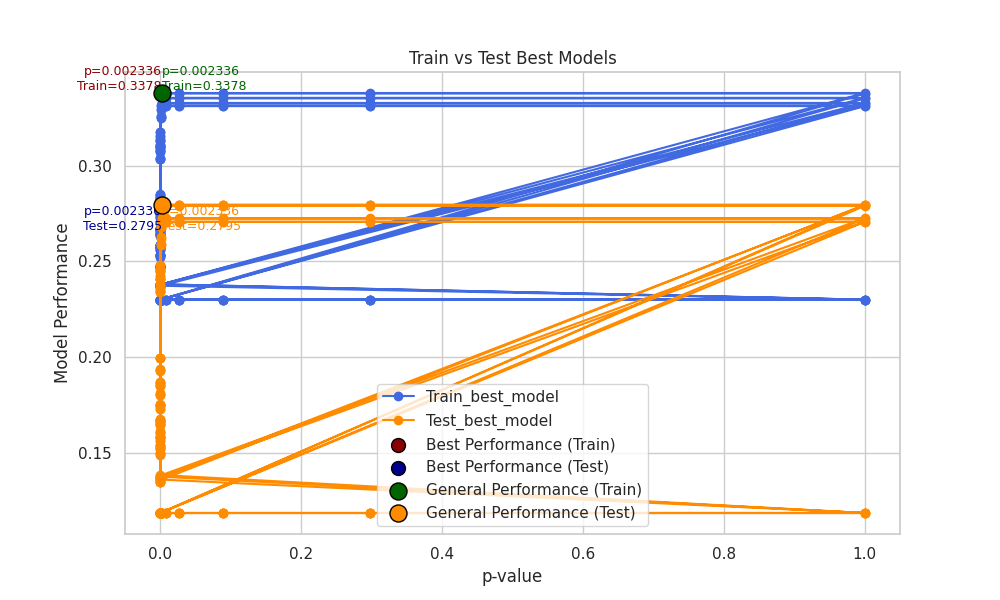

2. Reporting Generalized Performance:

|                  | 74                     |
|:-----------------|:-----------------------|
| clump_p1         | 1.0                    |
| clump_r2         | 0.1                    |
| clump_kb         | 200.0                  |
| p_window_size    | 200.0                  |
| p_slide_size     | 50.0                   |
| p_LD_threshold   | 0.25                   |
| pvalue           | 0.0023357214690901     |
| numberofpca      | 6.0                    |
| tempalpha        | 0.1                    |
| l1weight         | 0.1                    |
| numberofvariants | 173107.8               |
| heritability     | 0.2032220489181616     |
| Train_pure_prs   | 1.6089980132694137e-06 |
| Train_null_model | 0.23001030414198947    |
| Train_best_model | 0.33784656323625945    |
| Test_pure_prs    | 1.6322806513313638e-06 |
| Test_null_model  | 0.11869244971793831    |
| Test_best_model  | 0.2794866954995853     |
| referencepanel   | ref                 

<IPython.core.display.Javascript object>


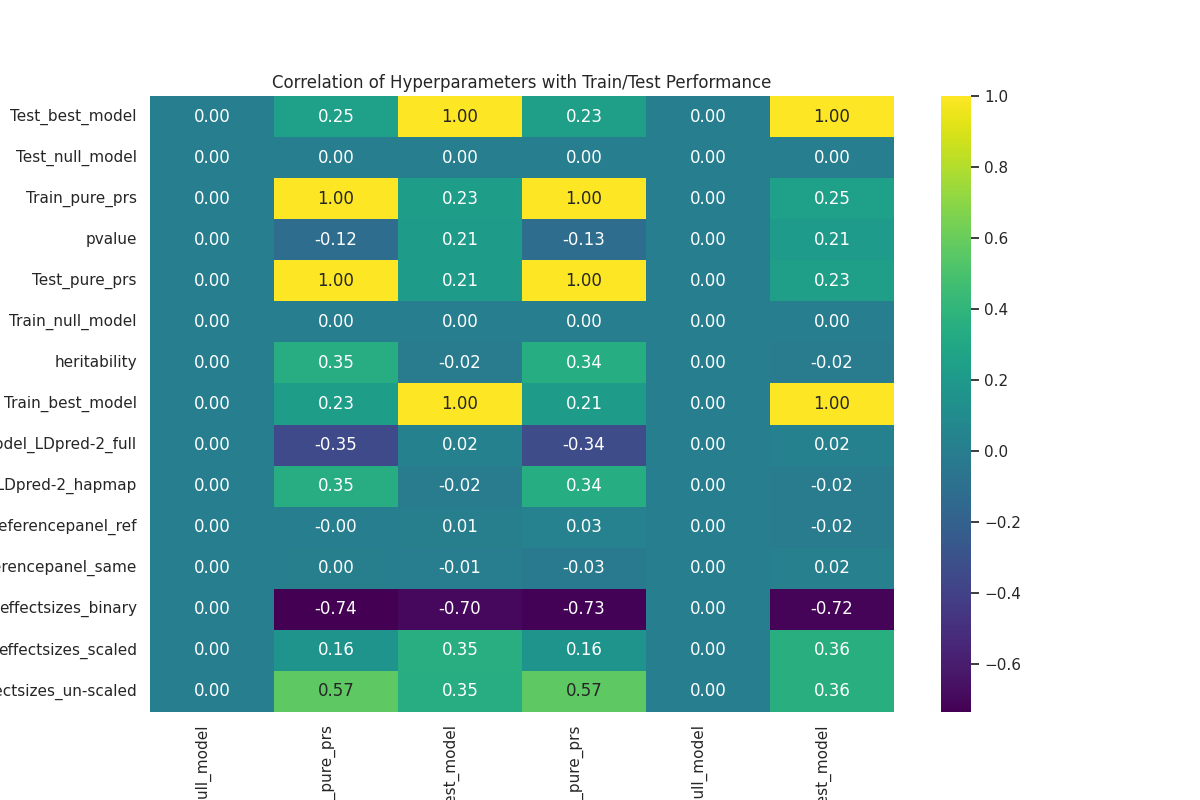

<IPython.core.display.Javascript object>


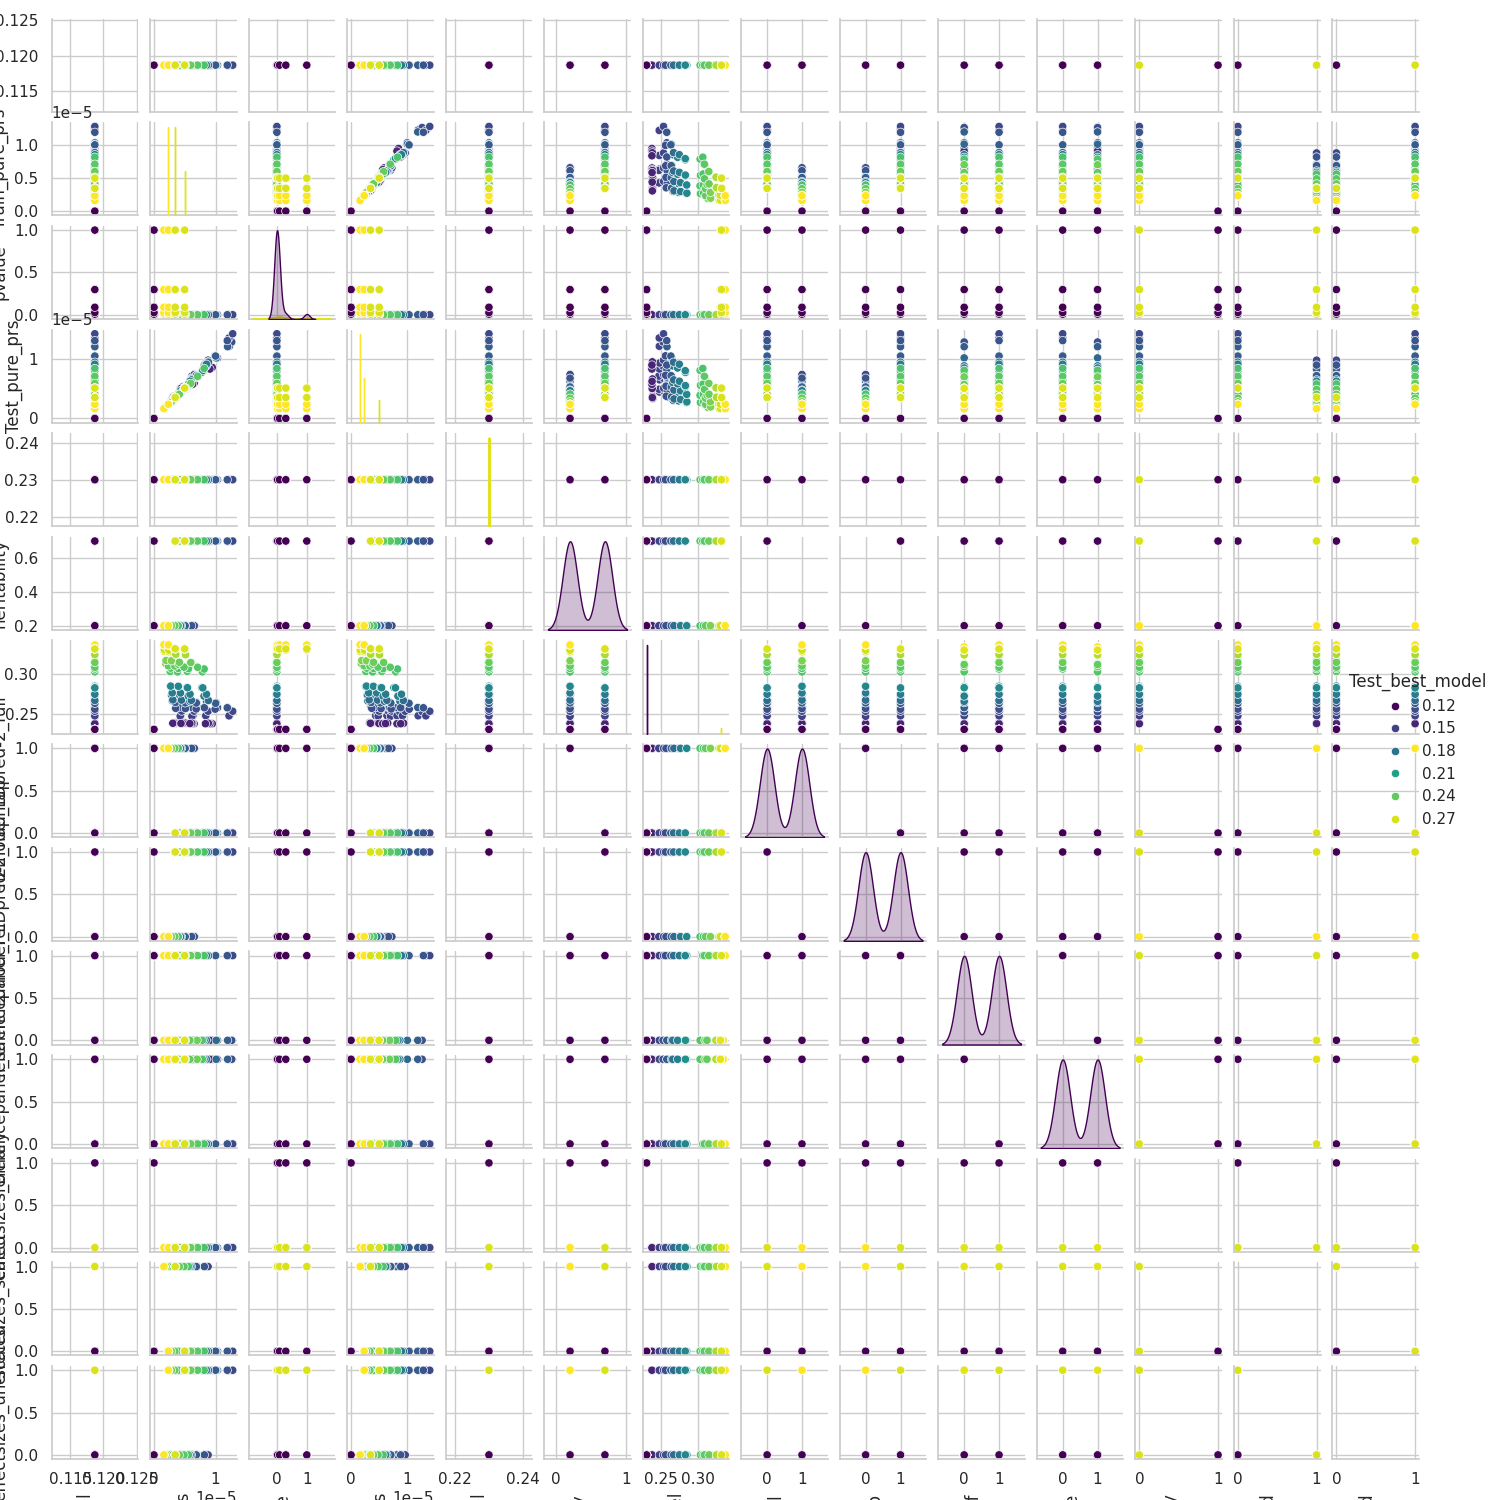

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
df = divided_result.sort_values(by='Train_best_model', ascending=False)
print("1. Reporting Based on Best Training Performance:\n")
print(df.iloc[0].to_markdown())


 
df = divided_result.copy()

# Plot Train and Test best models against p-values
plt.figure(figsize=(10, 6))
plt.plot(df['pvalue'], df['Train_best_model'], label='Train_best_model', marker='o', color='royalblue')
plt.plot(df['pvalue'], df['Test_best_model'], label='Test_best_model', marker='o', color='darkorange')

# Highlight the p-value where both train and test are high
best_index = df[['Train_best_model']].sum(axis=1).idxmax()
best_pvalue = df.loc[best_index, 'pvalue']
best_train = df.loc[best_index, 'Train_best_model']
best_test = df.loc[best_index, 'Test_best_model']

# Use dark colors for the circles
plt.scatter(best_pvalue, best_train, color='darkred', s=100, label=f'Best Performance (Train)', edgecolor='black', zorder=5)
plt.scatter(best_pvalue, best_test, color='darkblue', s=100, label=f'Best Performance (Test)', edgecolor='black', zorder=5)

# Annotate the best performance with p-value, train, and test values
plt.text(best_pvalue, best_train, f'p={best_pvalue:.4g}\nTrain={best_train:.4g}', ha='right', va='bottom', fontsize=9, color='darkred')
plt.text(best_pvalue, best_test, f'p={best_pvalue:.4g}\nTest={best_test:.4g}', ha='right', va='top', fontsize=9, color='darkblue')

# Calculate Difference and Sum
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']

# Sort the DataFrame
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
#sorted_df = df.sort_values(by=[ 'Difference','Sum'], ascending=[  True,False])

# Highlight the general performance
general_index = sorted_df.index[0]
general_pvalue = sorted_df.loc[general_index, 'pvalue']
general_train = sorted_df.loc[general_index, 'Train_best_model']
general_test = sorted_df.loc[general_index, 'Test_best_model']

plt.scatter(general_pvalue, general_train, color='darkgreen', s=150, label='General Performance (Train)', edgecolor='black', zorder=6)
plt.scatter(general_pvalue, general_test, color='darkorange', s=150, label='General Performance (Test)', edgecolor='black', zorder=6)

# Annotate the general performance with p-value, train, and test values
plt.text(general_pvalue, general_train, f'p={general_pvalue:.4g}\nTrain={general_train:.4g}', ha='left', va='bottom', fontsize=9, color='darkgreen')
plt.text(general_pvalue, general_test, f'p={general_pvalue:.4g}\nTest={general_test:.4g}', ha='left', va='top', fontsize=9, color='darkorange')

# Add labels and legend
plt.xlabel('p-value')
plt.ylabel('Model Performance')
plt.title('Train vs Test Best Models')
plt.legend()
plt.show()
 




print("2. Reporting Generalized Performance:\n")
df = divided_result.copy()
df['Difference'] = abs(df['Train_best_model'] - df['Test_best_model'])
df['Sum'] = df['Train_best_model'] + df['Test_best_model']
sorted_df = df.sort_values(by=['Sum', 'Difference'], ascending=[False, True])
print(sorted_df.iloc[0].to_markdown())


print("3. Reporting the correlation of hyperparameters and the performance of 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model':\n")

print("3. For string hyperparameters, we used one-hot encoding to find the correlation between string hyperparameters and 'Train_null_model', 'Train_pure_prs', 'Train_best_model', 'Test_pure_prs', 'Test_null_model', and 'Test_best_model'.")

print("3. We performed this analysis for those hyperparameters that have more than one unique value.")

correlation_columns = [
 'Train_null_model', 'Train_pure_prs', 'Train_best_model',
 'Test_pure_prs', 'Test_null_model', 'Test_best_model'
]

hyperparams = [col for col in divided_result.columns if len(divided_result[col].unique()) > 1]
hyperparams = list(set(hyperparams+correlation_columns))
 
# Separate numeric and string columns
numeric_hyperparams = [col for col in hyperparams if pd.api.types.is_numeric_dtype(divided_result[col])]
string_hyperparams = [col for col in hyperparams if pd.api.types.is_string_dtype(divided_result[col])]


# Encode string columns using one-hot encoding
divided_result_encoded = pd.get_dummies(divided_result, columns=string_hyperparams)

# Combine numeric hyperparams with the new one-hot encoded columns
encoded_columns = [col for col in divided_result_encoded.columns if col.startswith(tuple(string_hyperparams))]
hyperparams = numeric_hyperparams + encoded_columns
 

# Calculate correlations
correlations = divided_result_encoded[hyperparams].corr()
 
# Display correlation of hyperparameters with train/test performance columns
hyperparam_correlations = correlations.loc[hyperparams, correlation_columns]
 
hyperparam_correlations = hyperparam_correlations.fillna(0)

# Plotting the correlation heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(hyperparam_correlations, annot=True, cmap='viridis', fmt='.2f', cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

# Rotate y-axis labels to horizontal
#ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')

plt.title('Correlation of Hyperparameters with Train/Test Performance')
plt.show() 

sns.set_theme(style="whitegrid")  # Choose your preferred style
pairplot = sns.pairplot(divided_result_encoded[hyperparams],hue = 'Test_best_model', palette='viridis')

# Adjust the figure size
pairplot.fig.set_size_inches(15, 15)  # You can adjust the size as needed

for ax in pairplot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=90, ha='right')  # X-axis labels vertical
    #ax.set_ylabel(ax.get_ylabel(), rotation=0, va='bottom')  # Y-axis labels horizontal

# Show the plot
plt.show()


